<a href="https://colab.research.google.com/github/AgunsBaba/Assignment/blob/master/BeltExam2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [258]:
#import modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [259]:
#import data
df = pd.read_csv('/content/Belt2_A_drugtype_v2_final.csv')
df.head()

,Age,Gender,BP,Cholesterol,Na_to_K,Drug
0,59.0,M,High,HIGH,13.935,drugQ
1,40.0,F,Normal,HIGH,10.103,drugZ
2,NaN,M,Normal,HIGH,9.084,drugZ
3,62.0,M,Normal,HIGH,16.594,drugZ
4,55.0,F,High,NORMAL,10.977,drugQ


In [260]:
#check general data outline
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          237 non-null    float64
 1   Gender       296 non-null    object 
 2   BP           221 non-null    object 
 3   Cholesterol  296 non-null    object 
 4   Na_to_K      296 non-null    object 
 5   Drug         296 non-null    object 
dtypes: float64(1), object(5)
memory usage: 14.0+ KB


Based on result above, (1) the Age and BP columns have some null values that must be handled, (2) there are 4 columns with an 'object' data type, and one column with a 'float' data type

In [261]:
#check duplicates
df.duplicated().sum()

15

There are 15 duplicates that need to be dropped

In [262]:
#remove duplicates
df.drop_duplicates(inplace=True)

In [263]:
#confirm duplicates have been dropped
df.duplicated().sum()

0

Duplicates have been removed

In [264]:
#check general data outline after removing duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281 entries, 0 to 295
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          227 non-null    float64
 1   Gender       281 non-null    object 
 2   BP           206 non-null    object 
 3   Cholesterol  281 non-null    object 
 4   Na_to_K      281 non-null    object 
 5   Drug         281 non-null    object 
dtypes: float64(1), object(5)
memory usage: 15.4+ KB


In [265]:
#check the class balance
df['Drug'].value_counts(normalize=True)

drugZ    0.523132
drugQ    0.476868
Name: Drug, dtype: float64

In [266]:
#check inconsistencies in categories
cols = ['Gender', 'BP', 'Cholesterol']
for i in cols:
  print(df[i].value_counts().to_markdown())

|        |   Gender |
|:-------|---------:|
| M      |      140 |
| F      |      131 |
| male   |        4 |
| female |        2 |
| femal  |        1 |
| Female |        1 |
| Femal  |        1 |
| Male   |        1 |
|        |   BP |
|:-------|-----:|
| High   |  128 |
| Normal |   46 |
| Low    |   32 |
|        |   Cholesterol |
|:-------|--------------:|
| HIGH   |           145 |
| NORMAL |           114 |
| norm   |             9 |
| high   |             7 |
| NORM   |             6 |


Based on the result above, there are some inconsistent categories for Gender and Cholesterol that must be handled

In [267]:
#handle inconsistencies for the columns

#handle the Gender column
df['Gender'].replace(to_replace={'male': 'M', 'Male': 'M', 'female': 'F', 
                                 'femal': 'F', 'Female': 'F', 'Femal': 'F'}, 
                     value=None, inplace=True) 

#handle the Cholesterol column
df['Cholesterol'].replace(to_replace={'norm': 'NORMAL', 'NORM': 'NORMAL', 
                                      'high': 'HIGH'}, value=None, inplace=True) 

In [268]:
#check that inconsistencies have been handled
cols = ['Gender', 'Cholesterol']
for i in cols:
  print(df[i].value_counts().to_markdown())

|    |   Gender |
|:---|---------:|
| M  |      145 |
| F  |      136 |
|        |   Cholesterol |
|:-------|--------------:|
| HIGH   |           152 |
| NORMAL |           129 |


Based on the data dictionary, Na_to_K should be of dtype float but it is an object in the dataset. This needs to be investigated and fixed. On running the df['Na_to_K'].astype(float) to convert the colum to float, it returned an error ValueError: could not convert string to float: '10.403_'. Therefore the string in the column must be changed to a float after which the whole column will then be changed to float. 

In [269]:
#Replace string in the Na_to_K column
df['Na_to_K'].replace(to_replace={'10.403_': 10.403}, value=None, inplace=True)

#convert whole column to float
df['Na_to_K'] = df['Na_to_K'].astype(float)

In [270]:
#check to confirm the Na_to_K column is now float dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281 entries, 0 to 295
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          227 non-null    float64
 1   Gender       281 non-null    object 
 2   BP           206 non-null    object 
 3   Cholesterol  281 non-null    object 
 4   Na_to_K      281 non-null    float64
 5   Drug         281 non-null    object 
dtypes: float64(2), object(4)
memory usage: 15.4+ KB


In [271]:
#generate summary statistics for the dataset
df.describe()

,Age,Na_to_K
count,227.000000,281.000000
mean,47.475771,14.862769
std,38.359652,6.474826
min,15.000000,6.269000
25%,32.000000,10.446000
50%,45.000000,12.856000
75%,59.000000,17.206000
max,570.000000,38.247000


From the result above, there's an entry with a maximum age of 570 years which is an unreasonable outlier. Since there's no way to know what the age is for this entry I'll go ahead and delete it.

In [272]:
#delete entry with Age = 570
df = df[df.Age != 570]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280 entries, 0 to 295
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          226 non-null    float64
 1   Gender       280 non-null    object 
 2   BP           205 non-null    object 
 3   Cholesterol  280 non-null    object 
 4   Na_to_K      280 non-null    float64
 5   Drug         280 non-null    object 
dtypes: float64(2), object(4)
memory usage: 15.3+ KB


In [273]:
df.describe()

,Age,Na_to_K
count,226.000000,280.000000
mean,45.163717,14.865079
std,16.098439,6.486304
min,15.000000,6.269000
25%,32.000000,10.446000
50%,44.500000,12.856000
75%,58.750000,17.207250
max,74.000000,38.247000


In [274]:
df['BP'].value_counts(normalize=True)

High      0.624390
Normal    0.219512
Low       0.156098
Name: BP, dtype: float64

The BP columns has some missing values too and I'll handle those during data pre-processing

**Exploratory Visualization**

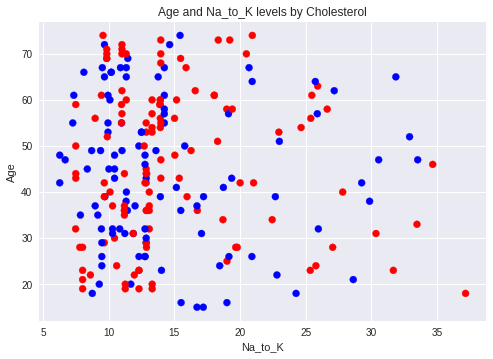

In [275]:
#Plot scatterplot of Age and Na_to_K level by cholesterol level
chole = list(df['Cholesterol'])
colors = {'HIGH': 'red', 'NORMAL': 'blue'}
color_list = [colors[i] for i in chole]
plt.scatter(df['Na_to_K'], df['Age'], c=color_list)
plt.ylabel('Age')
plt.xlabel('Na_to_K')
plt.title('Age and Na_to_K levels by Cholesterol')
plt.show()

From the visualization above, there seems to be no difference in cholesterol level by age. Similarly, there seems to be no difference in cholestoerol level by NA_to_K levels. 

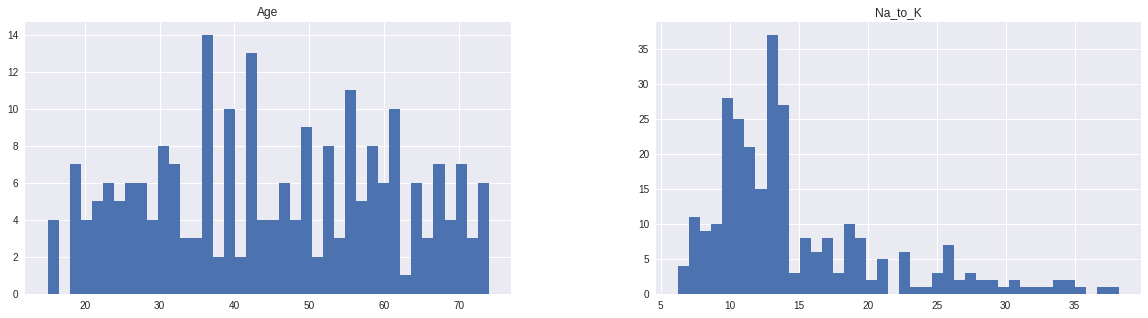

In [276]:
#Generate histogram of numerical columns in dataset to explore distribution

df.hist(figsize=(20,5), bins=40)
plt.show()

In the plot above, the distribution of the Age is multi-modal (with multiple peaks in the distribution) while the distribution of Na_to_K is skewed to the right

**Data Preprocessing**

In [277]:
#split data into X and y
X = df.drop(columns='Drug')
y = df['Drug']

In [278]:
#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Strategy for Replacing Missing and Null Values**

There are null values in the Age column. To handle this I'll use the SimpleImputter() function with the default strategy which is 'mean'. I'm using 'mean' because it is convenient and does not change the shape of the distribution.



There are missing values in the BP column. To handle this, I'll use the SimpleImputter() function and set the strategy to 'most_frequent'. I'm using 'most_frequent' because the original dataset has the value 'High' occuring more than 60% in the BP column. It is logical to therefore fill the missing values with the most occuring. 

In [279]:
#Data preprocessing

#Columns selectors
cat_col = make_column_selector(dtype_include=object) #select categorical columns
num_col = make_column_selector(dtype_exclude=object) #select numerical columns

#Create Inputter strategy for missing values
cat_input = SimpleImputer(strategy='most_frequent')
num_input = SimpleImputer()

oht = OneHotEncoder(sparse=False, handle_unknown='ignore') #instantiate one hot encoder transfromer
scaler = StandardScaler() #instantiate scaler transformer

#make pipelines for the data transformation
cat_pipe = make_pipeline(cat_input, oht)
num_pipe = make_pipeline(num_input, scaler)

#create pre-processing tuples
cat_tuple = (cat_pipe, cat_col)
num_tuple =(num_pipe, num_col)

#make columns_transformers
col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')

**Initial Model Instantiation, Fitting and Classification Report Generation for the LGBM Model**

---

For this exercise, I am going to use the LGBM and XGB models

In [280]:
#instantiate models
lgbm = LGBMClassifier(random_state=42)

#create model pipelines
lgbm_pipe = make_pipeline(col_transformer, lgbm)

In [281]:
#fit the lgbm model
lgbm_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2702209650>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                   

In [282]:
#generate lgbm classification report
pred_lgbm = lgbm_pipe.predict(X_test)
pred_lgbm_train = lgbm_pipe.predict(X_train)

print(classification_report(y_test, pred_lgbm))
print(classification_report(y_train, pred_lgbm_train))

              precision    recall  f1-score   support

       drugQ       0.89      0.97      0.93        34
       drugZ       0.98      0.92      0.95        50

    accuracy                           0.94        84
   macro avg       0.94      0.95      0.94        84
weighted avg       0.94      0.94      0.94        84

              precision    recall  f1-score   support

       drugQ       0.97      0.99      0.98       100
       drugZ       0.99      0.97      0.98        96

    accuracy                           0.98       196
   macro avg       0.98      0.98      0.98       196
weighted avg       0.98      0.98      0.98       196



**Tuning and Fitting the LGBM Hyperparameters and Generating Accuracy Report**


In [283]:
#get lgbm hyperparameters to tune
lgbm_pipe.get_params()


{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline-1',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2702209650>),
                                 ('pipeline-2',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  <skle

I'll tune the max_depth and n_estimators hyperparameters for the LGBM model

In [284]:
#create a hyperparameter dictionary
lgbm_param = {'lgbmclassifier__max_depth': [1, 10, 20 ],
              'lgbmclassifier__n_estimators': [100, 200, 300]}

grid_lgbm = GridSearchCV(lgbm_pipe, lgbm_param) #instantiate GridSearch            

In [285]:
grid_lgbm.fit(X_train, y_train) #fit the GridSearch

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f2702209650>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[

In [286]:
#create an lgbm pipeline with the best estimators
lgbm_best = grid_lgbm.best_estimator_ #I leveraged the feedback Josh gave me in the week 8 assignment for this code 😊
lgbm_best

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2702015490>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                   

In [287]:
#fit lgbm pipeline with the best estimators
lgbm_best.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2702015490>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                   

In [288]:
#generate lgbm classification report for tuned hyperparameters
pred_lgbm_best = lgbm_best.predict(X_test)
pred_lgbm_train_best = lgbm_best.predict(X_train)

print(classification_report(y_test, pred_lgbm_best))
print(classification_report(y_train, pred_lgbm_train_best))

              precision    recall  f1-score   support

       drugQ       0.89      1.00      0.94        34
       drugZ       1.00      0.92      0.96        50

    accuracy                           0.95        84
   macro avg       0.95      0.96      0.95        84
weighted avg       0.96      0.95      0.95        84

              precision    recall  f1-score   support

       drugQ       0.90      1.00      0.95       100
       drugZ       1.00      0.89      0.94        96

    accuracy                           0.94       196
   macro avg       0.95      0.94      0.94       196
weighted avg       0.95      0.94      0.94       196



The accuracy report for the tuned lgbm model is better than the accuracy report for the original untuned lgbm model. For instance, precision for drugQ in the original lgbm model was 0.89 and 0.97 respectively for test and train data which is an evidence of overfitting on the training data. However, the precision for drugQ in the tuned lgbm model was 0.89 and 0.90 respectively for test and train data and the fact that these numbers are almost equal means the tuned lgbm model isn't overfitting on the training data. I will compare the performance of the tuned lgbm model to the best performing xgb model (untuned vs tuned) to select the best model

**Initial Model Instantiation, Fitting and Classification Report Generation for the XGB Model**

In [289]:
#instantiate model
xgb = XGBClassifier(random_state=42)

#create model pipeline
xgb_pipe = make_pipeline(col_transformer, xgb)

In [290]:
%%time
#fit the xgb model
xgb_pipe.fit(X_train, y_train)

CPU times: user 43 ms, sys: 1.95 ms, total: 44.9 ms
Wall time: 45.3 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2702209650>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                   

In [291]:
#generate xgb classification report
pred_xgb = xgb_pipe.predict(X_test)
pred_xgb_train = xgb_pipe.predict(X_train)

print(classification_report(y_test, pred_xgb))
print(classification_report(y_train, pred_xgb_train))

              precision    recall  f1-score   support

       drugQ       0.89      0.97      0.93        34
       drugZ       0.98      0.92      0.95        50

    accuracy                           0.94        84
   macro avg       0.94      0.95      0.94        84
weighted avg       0.94      0.94      0.94        84

              precision    recall  f1-score   support

       drugQ       0.95      1.00      0.98       100
       drugZ       1.00      0.95      0.97        96

    accuracy                           0.97       196
   macro avg       0.98      0.97      0.97       196
weighted avg       0.98      0.97      0.97       196



**Tuning and Fitting the XGB Hyperparameters and Generating Accuracy Report**


In [292]:
xgb_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline-1',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2702209650>),
                                 ('pipeline-2',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  <skle

I'll tune the max_depth and n_estimators hyperparameters for the xgb model

In [293]:
#create a hyperparameter dictionary
xgb_param = {'xgbclassifier__max_depth': [4, 10, 20 ],
              'xgbclassifier__n_estimators': [100, 200, 300]}

grid_xgb = GridSearchCV(xgb_pipe, xgb_param) #instantiate GridSearch    

In [294]:
#fit the grid search
grid_xgb.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f2702209650>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[

In [295]:
#create an xgb pipeline with the best estimators
xgb_best = grid_xgb.best_estimator_ #I leveraged the feedback Josh gave me in the week 8 assignment for this code 😊
xgb_best

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f270207c790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                   

In [296]:
#fit xgb pipeline with the best estimators
xgb_best.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f270207c790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                   

In [297]:
#generate xgb classification report for tuned hyperparameters
pred_xgb_best = xgb_best.predict(X_test)
pred_xgb_train_best = xgb_best.predict(X_train)

print(classification_report(y_test, pred_xgb_best))
print(classification_report(y_train, pred_xgb_train_best))

              precision    recall  f1-score   support

       drugQ       0.92      1.00      0.96        34
       drugZ       1.00      0.94      0.97        50

    accuracy                           0.96        84
   macro avg       0.96      0.97      0.96        84
weighted avg       0.97      0.96      0.96        84

              precision    recall  f1-score   support

       drugQ       0.97      1.00      0.99       100
       drugZ       1.00      0.97      0.98        96

    accuracy                           0.98       196
   macro avg       0.99      0.98      0.98       196
weighted avg       0.99      0.98      0.98       196



The accuracy report for the tuned xgb model is better than the accuracy report for the original untuned xgb model. For example, the tuned xgb model improved the precision for drugQ to 0.92 from an original score of 0.89 (on the test data) in the original untuned model. Such precision improvement is also observed for drugZ.

**Model Recommendation**

Based on the analysis above, I'll recommend that the tuned xgb model be implemented. The basis for the recommendation is that the precision and accuracy of the tuned xgb model on the test data is better that those of the tuned lgbm model on the test data